In [1]:
!pip install python-igraph
!pip install plotly
from tqdm.notebook import tqdm
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import igraph
from igraph import Graph, EdgeSeq


In [2]:
data=np.load("celles.npy",allow_pickle=True)

In [3]:
data=np.array(data)

In [4]:
np.shape(data)

(48,)

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1035917178.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0" (-> color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)). The keyword argument will take precedence.
  ax.plot(data[0]["SOH"],'C0', label='normal decrease of soh '+data[0]["charge_policy"][0],color='green') # true soh (green)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1035917178.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C8" (-> color=(0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)). The keyword argument will take precedence.
  ax.plot(data[8]["SOH"],'C8', label='disnormal decrease of soh '+data[8]["charge_policy"][0],color='orange')
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1035917178.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C6" (-> color=(0.8

Text(0, 0.5, 'SOH')

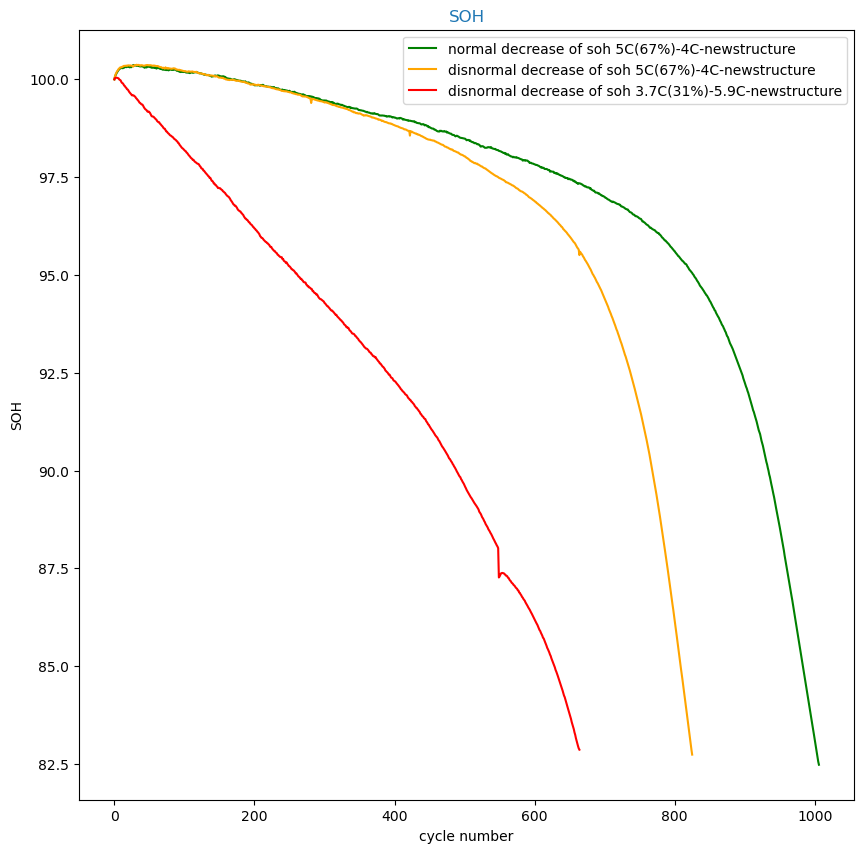

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('SOH', color='C0')
ax.plot(data[0]["SOH"],'C0', label='normal decrease of soh '+data[0]["charge_policy"][0],color='green') # true soh (green)
ax.plot(data[8]["SOH"],'C8', label='disnormal decrease of soh '+data[8]["charge_policy"][0],color='orange')
ax.plot(data[6]["SOH"],'C6', label='disnormal decrease of soh '+data[6]["charge_policy"][0],color='red') 

ax.legend()
plt.xlabel("cycle number")
plt.ylabel("SOH")

In [6]:
def derive(data):
    d=[]
    for i in range(1,len(data),1):
        j=(data[i]-data[i-1])
        d.append(j)
    return d

In [7]:
def compare(data1,data2,soh1,soh2):
    size=min(len(data1),len(data2))
    t=abs(np.array(data1[0:size])-np.array(data2[0:size]))
    p=[]
    for i in range(len(t)):
        if(t[i]>=0.035):
            x=100-((soh2[i+1]*100)/soh1[i+1])
            p.append((i+1,data1[i],data2[i],soh1[i+1],soh2[i+1],x))
    return p
    

In [8]:
def select(d):
    p=[]
    for i in range(len(d)):
        if(d[i][5]>=1):
            p.append(d[i])
    return p

In [9]:
def events_extract(k,data):
    o=[]
    for j in range(len(k)):
            o.append(np.array(data[["Ic", "Id", "Vc", "Vd", "Tc", "Td","charge_policy"]][(k[j][0]-10):k[j][0]]))
            o.append((k[j][0],k[j][5]))
    return o

In [10]:
def getEvents(data1,data2):
    dtrue_values=derive(data1["SOH"])
    dfalse_values=derive(data2["SOH"])
    p=compare(dtrue_values,dfalse_values,data1["SOH"],data2["SOH"])
    k=select(p)
    o=events_extract(k,data2)
    
    return o
    

In [11]:
class Data:
  def __init__(self,ic,id,vc,vd,tc,td):
    self.ic = ic
    self.vc = vc
    self.id = id
    self.vd = vd
    self.tc = tc
    self.td = td
    
    
  def __str__(self):
    return f"ic:{self.ic},id:{self.id},vc:{self.vc},vd:{self.vd},tc:{self.tc},td:{self.td}"

In [12]:
class Event:
   def __init__(self, data,time):
     self.data = data
     self.time = time
   def __str__(self):
    return f"(({self.data}),{self.time})"

In [13]:
class Chronicle:
    def __init__(self):
       self.event = []
    
    def addEvent(self, event):
       self.event.append(event)
    def plot(self):
        import networkx as nx
        G = nx.DiGraph()
        for i in range(len(self.event)):
            G.add_node(self.event[i].data)
            if(i+1<len(self.event)):
                G.add_edge(self.event[i].data, self.event[i+1].data, label="[0,"+str(self.event[i+1].time-self.event[i].time)+"]",arrows=True)

        # Draw the graph with edge labels
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True,node_color='#E1F4F9')
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

In [14]:
def compare_graphs(d1,d2):
    size=min(len(d1),len(d2))
    corr = np.corrcoef(d1[0:size], d2[0:size])[0, 1]
    return corr>=0.93


In [15]:
def equal(d1,d2):
    return (d1[0]==d2[0] and d1[1]==d2[1] and  d1[2]==d2[2] and d1[3]==d2[3] and d1[4]==d2[4] and d1[5]==d2[5])

In [16]:
def createdf(data1,data2):
    events=getEvents(data1,data2)
    s=0
    datat=[]
    result=[]
    for i in range(0,len(events),2):
        data=[]
        s=(events[i+1][0])-10
        for j in range(len(events[i])):
            data.append((events[i][j],s))
            s=s+1
        result.append(events[i+1][1])
        datat.append(data)
    return datat,result

In [17]:
def getd(df_midum,ic,id,vc,vd,tc,td):
    Total_data_m=[]
    for i in range(len(df_midum)):
        data=[]
        for j in range(10):

            find=False
            for k in range(len(ic)):
                if(compare_graphs(ic[k][0],df_midum["data"][i][j][0][0]) and ic[k][1]==df_midum["data"][i][j][0][6] ):
                    IC="ic"+str(k)
                    find=True
                    break
            
            if(not find):
                ic.append((df_midum["data"][i][j][0][0],df_midum["data"][i][j][0][6]))
                IC="ic"+str(len(ic)+1)
            find=False
            for k in range(len(id)):
                if(compare_graphs(id[k][0],df_midum["data"][i][j][0][1]) and id[k][1]==df_midum["data"][i][j][0][6]):
                    ID="id"+str(k)
                    find=True
                    break
            if(not find):
                id.append((df_midum["data"][i][j][0][1],df_midum["data"][i][j][0][6]))
                ID="id"+str(len(id)+1)
            find=False
            for k in range(len(vc)):
                if(compare_graphs(vc[k][0],df_midum["data"][i][j][0][2]) and vc[k][1]==df_midum["data"][i][j][0][6]):
                    VC="vc"+str(k)
                    find=True
                    break
            if(not find):
                vc.append((df_midum["data"][i][j][0][2],df_midum["data"][i][j][0][6]))
                VC="vc"+str(len(vc)+1)
            find=False
            for k in range(len(vd)):
                if(compare_graphs(vd[k][0],df_midum["data"][i][j][0][3]) and vd[k][1]==df_midum["data"][i][j][0][6]):
                    VD="vd"+str(k)
                    find=True
                    break
            if( not find):
                vd.append((df_midum["data"][i][j][0][3],df_midum["data"][i][j][0][6]))
                VD="vd"+str(len(vd)+1)
            find=False
            for k in range(len(tc)):
                if(compare_graphs(tc[k][0],df_midum["data"][i][j][0][4])and tc[k][1]==df_midum["data"][i][j][0][6]):
                    TC="tc"+str(k)
                    find=True
                    break
            if(not find):
                tc.append((df_midum["data"][i][j][0][4],df_midum["data"][i][j][0][6]))
                TC="tc"+str(len(tc)+1)
            find=False
            for k in range(len(td)):
                if(compare_graphs(td[k][0],df_midum["data"][i][j][0][5])and td[k][1]==df_midum["data"][i][j][0][6]):
                    TD="td"+str(k)
                    find=True
                    break
            if(not find):
                td.append((df_midum["data"][i][j][0][5],df_midum["data"][i][j][0][6]))
                TD="td"+str(len(td)+1)
            data.append((IC,ID,VC,VD,TC,TD,df_midum["data"][i][j][1]))
        Total_data_m.append(data)
    return Total_data_m

In [18]:
def getting_db(data1,data2,ic,id,vc,vd,tc,td):
    datat,result=createdf(data1,data2)
    df=pd.DataFrame({"data":datat,"result":result})
    soh_bins = [1, 9, 14, np.inf]
# discretize the soh column
    df['result'] = pd.cut(df['result'], bins=soh_bins, labels=['low', 'midum', 'high'])
    df_low=df[df["result"]=="low"]
    df_midum=df[df["result"]=="midum"]
    df_high=df[df["result"]=="high"]
    df_low=df_low.reset_index(drop=True)
    df_midum=df_midum.reset_index(drop=True)
    df_high=df_high.reset_index(drop=True)
    
    datam=getd(df_midum,ic,id,vc,vd,tc,td)
    
    datah=getd(df_high,ic,id,vc,vd,tc,td)
    
    datal=getd(df_low,ic,id,vc,vd,tc,td)

    return datal,datam,datah
    
     
      
        

In [19]:
def getS(dataT,dataF):
    datam=pd.DataFrame()
    datal=pd.DataFrame()
    datah=pd.DataFrame()
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    for i in range(len(dataF)):
        l,m,h=getting_db(dataT,dataF[i],ic,id,vc,vd,tc,td)
        datal=datal.append(pd.DataFrame(l),ignore_index=True)
        datam=datam.append(pd.DataFrame(m),ignore_index=True)
        datah=datah.append(pd.DataFrame(h),ignore_index=True)
    
    return datal,datam,datah,ic,id,vc,vd,tc,td
        

In [20]:
def transfer(df_final):
    names=[df_final[0][0]]
    all_data=[]
    for i in range(len(df_final)):
        data=[]
        for j in range(10):
            find=False
            for k in range(len(names)):
                if(equal(names[k],df_final[j][i])):
                    find=True
                    data.append(("E"+str(k),df_final[j][i][6]))
                    break
            if (not find):
                data.append(("E"+str(k+1),df_final[j][i][6]))
                names.append(df_final[j][i])
        all_data.append(data)
    return all_data,names

In [21]:
dataf=[]
for i in range(1,len(data),1):
    dataf.append(data[i])
df_final1,df_final2,df_final3,ic,id,vc,vd,tc,td=getS(data[0],dataf)
all_data1,names1=transfer(df_final1)
all_data2,names2=transfer(df_final2)
all_data3,names3=transfer(df_final3)
    
df3=pd.DataFrame(all_data3)  
df1=pd.DataFrame(all_data1)
df2=pd.DataFrame(all_data2)




C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=data

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=data

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=data

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=data

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_6968\1392672330.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True)


In [40]:
df2.to_html("df24")

In [22]:
def frequence_sequences(all_data1):
    from prefixspan import PrefixSpan
    ps=PrefixSpan(all_data1)
    tr=ps.topk(5000, closed=True)
    frequent_item=[]
    for i in range(len(tr)):
        frequent_item.append(tr[i][1])
    return frequent_item 






In [23]:
frequent_itemsets_low=frequence_sequences(all_data1)
frequent_itemsets_midum=frequence_sequences(all_data2)
frequent_itemsets_high=frequence_sequences(all_data3)

In [24]:
def equiv(data1,data2,j,c):
    i=False
   
    if(compare_graphs(data1[0],data2[c][j])and data1[1]==data2["charge_policy"][j]):
        i=True
    return i

In [25]:
def get_graph(data,frequent_itemset,names,ic,id,vc,vd,tc,td):
    found=[]
    places=[]
    ic1=[]
    vc1=[]
    tc1=[]
    id1=[]
    vd1=[]
    td1=[]
    n=[]
    for i in range(len(frequent_itemset)):
        n.append(frequent_itemset[i][0])
        position=int(frequent_itemset[i][0][1:])
        item=names[position]
        ic1.append(ic[int(item[0][2:])])
        id1.append(id[int(item[1][2:])])
        vc1.append(vc[int(item[2][2:])])
        vd1.append(vd[int(item[3][2:])])
        tc1.append(tc[int(item[4][2:])])
        td1.append(td[int(item[5][2:])])  
    for i in range(len(data)):
        exist=True
        for j in range(len(ic1)):
            if(not (data[i+j:i+j+1].index.start==data[i+j:i+j+1].index.stop)):
                if (not(equiv(ic1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Ic") and equiv(id1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Id") and equiv(vc1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Vc") and equiv(vd1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Vd")  and equiv(tc1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Tc") and equiv(td1[j],data[i+j:i+j+1],data[i+j:i+j+1].index.start,"Td"))):
                    exist=False
                    break
        if(exist):
            places.append((n,i))
        found.append(exist)
        
    return found,places
        
    
    

In [26]:
def ploting_low(data1,data2,frequent_itemsets_low,ic,id,vc,vd,tc,td,names1):
    fig, ax = plt.subplots(figsize=(10, 10))
    SOH=data2["SOH"]
    ax.plot(data[0]["SOH"],label="norml graph",color="blue")
    ax.plot(SOH, label="abnorml graph",color='gray')
    ############low
    finished=False
    j=0
    fl=[]
    while(not finished):
        data2["detect_event_low"],places=get_graph(data2,frequent_itemsets_low[j],names1,ic,id,vc,vd,tc,td)
        fl.append(places)
        j=j+1
        if(j>=len(frequent_itemsets_low)):
            finished=True
        event_low=data2["detect_event_low"]
        ax.scatter(SOH[event_low].index,SOH[event_low], color='green',marker='*')
    ax.legend()
    plt.xlabel("cycle number")
    plt.ylabel("SOH")
    fig.savefig("edlow.pdf", format="pdf", dpi=1200)
    return fl

In [27]:
def ploting_medium(data1,data2,frequent_itemsets_medium,ic,id,vc,vd,tc,td,names2):
    fig, ax = plt.subplots(figsize=(10, 10))
    SOH=data2["SOH"]
    ax.plot(data[0]["SOH"],label="norml graph",color="blue")
    ax.plot(SOH, label="abnorml graph",color='gray')
    ###############midium
    finished=False
    j=0
    fm=[]
    while(not finished):
        data2["detect_event_midium"],places=get_graph(data2,frequent_itemsets_medium[j],names2,ic,id,vc,vd,tc,td)
        fm.append(places)
        j=j+1
        if(j>=len(frequent_itemsets_midum)):
            finished=True
        event_midium=data2["detect_event_midium"]
        ax.scatter(SOH[event_midium].index,SOH[event_midium], color='orange',marker='*')  
    ax.legend()
    plt.xlabel("cycle number")
    plt.ylabel("SOH")
    fig.savefig("edmedium.pdf", format="pdf", dpi=1200)
    return fm

In [28]:
def ploting_high(data1,data2,frequent_itemsets_high,ic,id,vc,vd,tc,td,names3):
    fig, ax = plt.subplots(figsize=(10, 10))
    SOH=data2["SOH"]
    ax.plot(data[0]["SOH"],label="norml graph",color="blue")
    ax.plot(SOH, label="abnorml graph",color='gray')
    #####################high
    finished=False
    j=0
    fh=[]
    while(not finished):
        data2["detect_event_high"],places=get_graph(data2,frequent_itemsets_high[j],names3,ic,id,vc,vd,tc,td)
        fh.append(places)
        j=j+1
        if(j>=len(frequent_itemsets_high)):
            finished=True
        event_high=data2["detect_event_high"]
        ax.scatter(SOH[event_high].index,SOH[event_high],color='red',marker='*')
    ax.legend()
    plt.xlabel("cycle number")
    plt.ylabel("SOH")
    fig.savefig("edhigh.pdf", format="pdf", dpi=1200)
    return fh

C:\Users\sarbaoui01\Anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


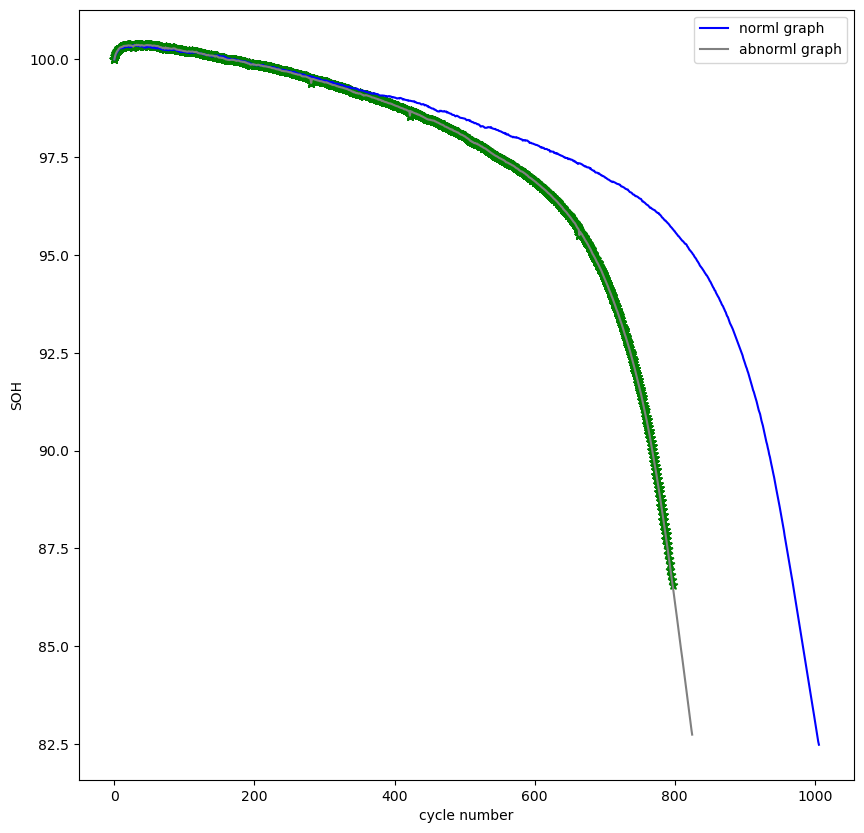

In [29]:
fl=ploting_low(data[0],data[8],frequent_itemsets_low,ic,id,vc,vd,tc,td,names1)

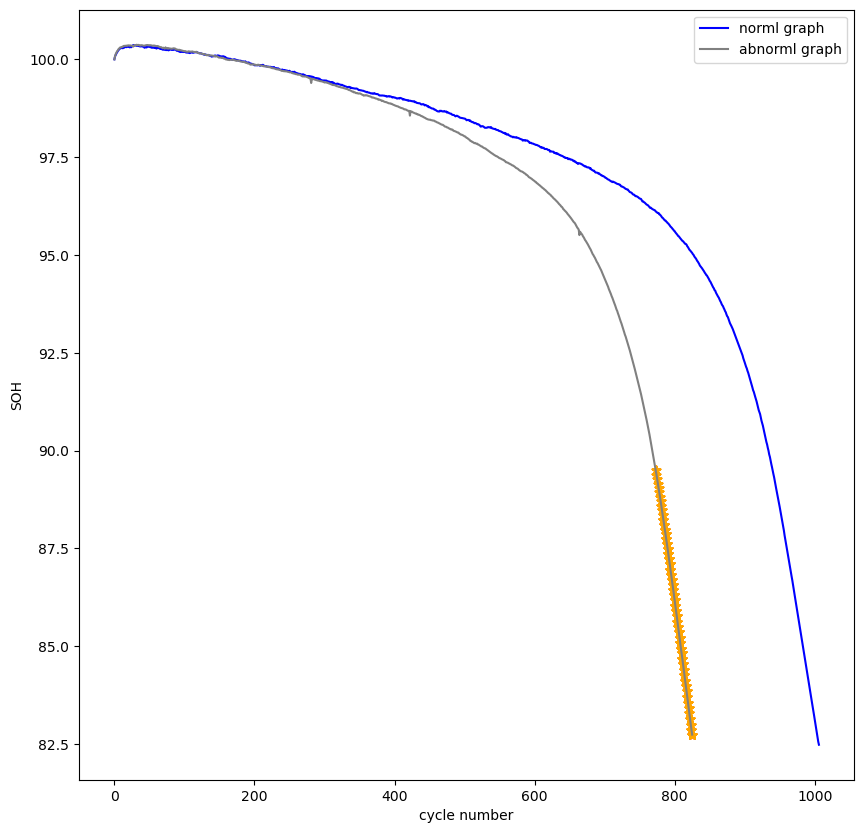

In [30]:
fm=ploting_medium(data[0],data[8],frequent_itemsets_midum,ic,id,vc,vd,tc,td,names2)

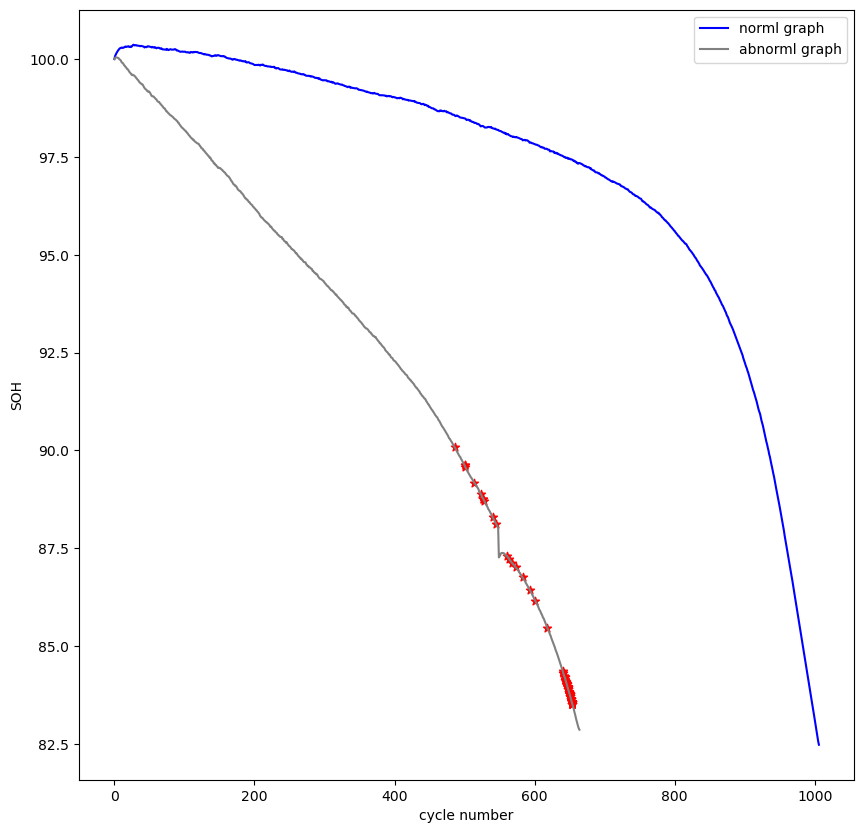

In [31]:
fh=ploting_high(data[0],data[6],frequent_itemsets_high,ic,id,vc,vd,tc,td,names3)

In [32]:
def create_chronicle(sequence,ic,id,vc,vd,tc,td,names):
    c=Chronicle()
    ic1=[]
    vc1=[]
    tc1=[]
    id1=[]
    vd1=[]
    td1=[]
    name=[]
    for i in range(len(sequence[0])):
        position=int(sequence[0][i][1:])
        c.addEvent(Event(sequence[0][i],int(sequence[1])+i))
        item=names[position]
        name.append(sequence[0][i])
        ic1.append(ic[int(item[0][2:])])
        id1.append(id[int(item[1][2:])])
        vc1.append(vc[int(item[2][2:])])
        vd1.append(vd[int(item[3][2:])])
        tc1.append(tc[int(item[4][2:])])
        td1.append(td[int(item[5][2:])])
    df=pd.DataFrame({"name":name,"ic":ic1,"id":id1,"vc":vc1,"vd":vd1,"tc":tc1,"td":td1})
    
    return c,df
    

In [33]:
chronicle,dff=create_chronicle(fh[150][0],ic,id,vc,vd,tc,td,names3)

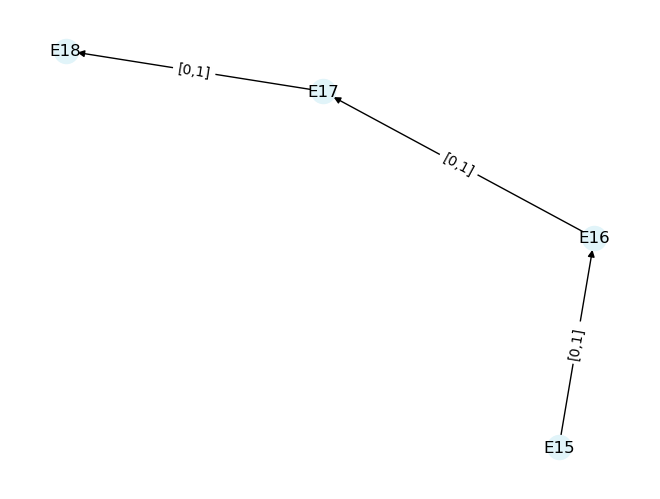

In [34]:
chronicle.plot()

In [41]:
dff.to_html("dff")